In [87]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import copy

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device  = "mps"
else:
    device  = "cpu"

from sklearn.decomposition import PCA 
import numpy as np
from matplotlib import pyplot as plt

In [5]:
batch_size = 128

trainset = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = torchvision.datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(testset ,batch_size = batch_size, shuffle=True)

In [6]:
class Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [132]:
train_times = 8
num_epochs = 50
# grad_all = {time: [] for time in range(train_times)}
# loss_all = {time: [] for time in range(train_times)}
# weights_all = {time: [] for time in range(train_times)}
grad_all = {}
loss_all = {}
weights_all = {}

for time in range(train_times):
    print(time)

    model = Model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

    loss_list = []
    grad_list = []
    weights_list = []

    for epoch in range(num_epochs):

        loss_per_epoch = 0
        model = model.to(device)
        model.train()

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device).reshape(-1, 28*28)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_per_epoch += loss.item() / len(train_loader)


        if epoch % 3 == 0:
            # store params and loss
            weights_list.append(copy.deepcopy(model.state_dict()))
            loss_list.append(loss_per_epoch)
            
            # compute grad L2 norm
            grad_all_epoch = 0.0
            for p in model.parameters(): 
                grad = 0.0
                if p.grad is not None:
                    grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all_epoch += grad
            grad_norm = grad_all_epoch ** 0.5
            
            # store grad norm
            grad_list.append(grad_norm)

    grad_all[time] = grad_list
    loss_all[time] = loss_list
    weights_all[time] = weights_list


0
1
2
3
4
5
6
7


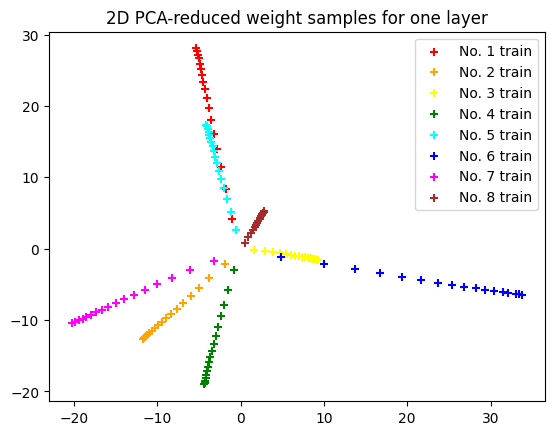

In [135]:
n_samples_per_session = len(weights_all[0])
n_samples = train_times * n_samples_per_session 
n_features = weights_all[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] 


PCA_input_data = np.zeros((n_samples, n_features))


for t in range(train_times):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = weights_all[t][i]['fc1.weight'].flatten().cpu().numpy()


reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)


colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(train_times):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+', label=f"No. {t+1} train")
plt.legend()
plt.title("2D PCA-reduced weight samples for one layer")
plt.show()

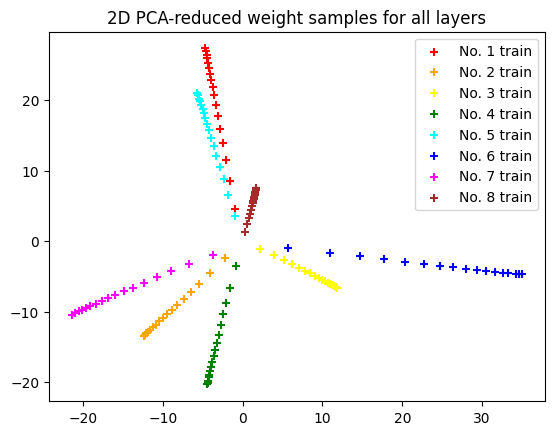

In [136]:
n_samples_per_session = len(weights_all[0])
n_samples = train_times * n_samples_per_session 
n_features = weights_all[0][0]['fc1.weight'].cpu().numpy().flatten().shape[0] + weights_all[0][0]['fc2.weight'].cpu().numpy().flatten().shape[0] + weights_all[0][0]['fc3.weight'].cpu().numpy().flatten().shape[0]


PCA_input_data = np.zeros((n_samples, n_features))

# populate high-dim input tensor 
for t in range(train_times):
    for i in range(n_samples_per_session): 
        PCA_input_data[t * n_samples_per_session + i, :] = np.append(weights_all[t][i]['fc1.weight'].flatten().cpu().numpy(), np.append(weights_all[t][i]['fc2.weight'].flatten().cpu().numpy(),weights_all[t][i]['fc3.weight'].flatten().cpu().numpy()))

reduced_data = PCA(n_components = 2).fit_transform(PCA_input_data)


colors = ["red", "orange", "yellow", "green", "cyan", "blue", "magenta", "brown"]
for t in range(train_times):
    plt.scatter(reduced_data.T[0][t*n_samples_per_session:(t+1)*n_samples_per_session], reduced_data.T[1][t*n_samples_per_session:(t+1)*n_samples_per_session], color=colors[t], marker='+', label=f"No. {t+1} train")
plt.legend()
plt.title("2D PCA-reduced weight samples for all layers")
plt.show()

In [151]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

loss_per_iter = []
grad_per_iter = []

for epoch in range(num_epochs):

    loss_per_epoch = 0
    model = model.to(device)
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device).reshape(-1, 28*28)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_per_iter.append(loss.item())

        loss_per_epoch += loss.item() / len(train_loader)

        grad_all_itr = 0.0
        for p in model.parameters(): 
            grad = 0.0
            if p.grad is not None:
                 grad = (p.grad.cpu().data.numpy() ** 2).sum()
            grad_all_itr += grad
        grad_norm = grad_all_itr ** 0.5
        grad_per_iter.append(grad_norm)

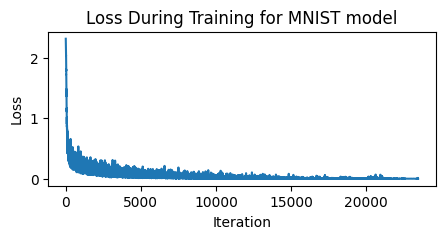

In [154]:

plt.figure(figsize=(5,2))
plt.plot(loss_per_iter)
plt.title('Loss During Training for MNIST model')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

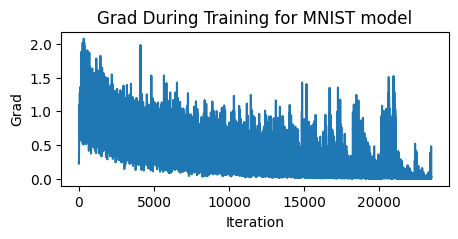

In [155]:
plt.figure(figsize=(5,2))
plt.plot(grad_per_iter)
plt.title('Grad During Training for MNIST model')
plt.xlabel("Iteration")
plt.ylabel("Grad")
plt.show()

In [173]:
summary(model.to('cpu'), input_size=(1,784), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2                [-1, 1, 32]           4,128
            Linear-3                [-1, 1, 10]             330
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


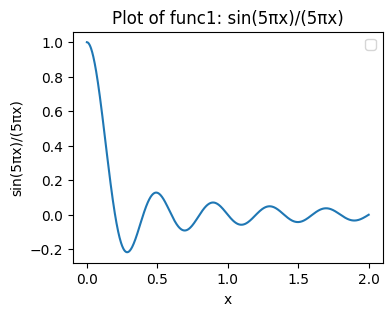

In [175]:
# Define the function
def func1(x):
    return np.sin(5 * np.pi * x) / (5 * np.pi * x)

# Generate x values
x1 = np.linspace(1e-6, 2, 1000)

# Compute y values
y1 = func1(x1)

# Plot the function
plt.figure(figsize=(4, 3))
plt.plot(x1, y1)
plt.title('Plot of func1: sin(5πx)/(5πx)')
plt.xlabel('x')
plt.ylabel('sin(5πx)/(5πx)')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.main(x)

def train_first_stage(model, train_loader, optimizer, criterion, epochs=1000):
    model.train()
    losses = []
    gradients = []
    minimal_ratios = []
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        progress_bar.set_description(f'Epoch: {epoch+1}/{epochs}')
    return losses, gradients, minimal_ratios

def epoch_loss(model, criterion, train_loader):
    with torch.no_grad():
        model.eval()
        losses = []
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            losses.append(loss.item())
        model.train()
    return sum(losses) / len(losses)


def train_second_stage(model, train_loader, optimizer, criterion, epochs=1000):
    model.train()
    losses = []
    gradients = []
    minimal_ratios = []
    progress_bar = tqdm(range(epochs))

    names = list(n for n, _ in model.named_parameters())
    def loss_hessian(params):
        y_hat = torch.func.functional_call(model, {n: p for n, p in zip(names, params)}, x)
        return criterion(y_hat, y)
    
    def closure():
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        return loss

    for epoch in progress_bar:
        for i, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            # optimizer.zero_grad()
            optimizer.step(closure)

        # Calculate gradient norm
        gradient = torch.cat([p.grad.flatten() for p in model.parameters()])
        gradient_norm = torch.norm(gradient, 2)
        if gradient_norm < 1e-2:
            losses.append(epoch_loss(model, criterion, train_loader))
            gradients.append(gradient_norm.item())
            hessian = torch.func.hessian(loss_hessian)(tuple(model.parameters()))
            num_pos_eig = 0
            num_all_eig = 0
            for hi in hessian:
                for tensor in hi:
                    # if not batches of square matrices, continue
                    if tensor.size(-1) != tensor.size(-2):
                        continue
                    eigenvalues = torch.linalg.eigvals(tensor)
                    positive_eigenvalues = (eigenvalues.real > 0).sum()
                    num_pos_eig += positive_eigenvalues
                    num_all_eig += eigenvalues.nelement()
            minimal_ratio = num_pos_eig / num_all_eig
            minimal_ratios.append(minimal_ratio.item())
            

        progress_bar.set_description(f'Epoch: {epoch+1}/{epochs}')

    return losses, gradients, minimal_ratios


In [ ]:
x = torch.linspace(1e-6, 2, 1000).reshape(-1, 1)
y = torch.sin(5 * torch.pi * x) / (5 * torch.pi * x)

# parameters
train_loader = torch.utils.data.DataLoader(list(zip(x, y)), batch_size=1000, shuffle=True)
lr = 1e-3
criterion = nn.MSELoss()
epochs = 750

repeat = 100
all_losses = []
all_minimum_ratios = []
for i in range(repeat):
    print(f'training repeat {i}')
    model = DNN().to(device)
    optimizer1 = optim.Adam(model.parameters(), lr=lr)
    optimizer2 = optim.LBFGS(model.parameters(), lr=lr, history_size=5)
    # train the model with original criterion for 700 epochs
    _, _, _ = train_first_stage(model, train_loader, optimizer1, criterion, epochs)
    losses, gradients, minimal_ratio = train_second_stage(model, train_loader, optimizer2, criterion, epochs) 
    print(f'loss: {losses}, gradient: {gradients}, minimal_ratio: {minimal_ratio}')
    # sample 100 points from the losses
    if len(losses) > 100:
        indices = np.random.choice(len(losses), 100, replace=False)
        losses = np.array(losses)[indices]
        minimal_ratio = np.array(minimal_ratio)[indices]
    else:
        losses = np.array(losses)
        minimal_ratio = np.array(minimal_ratio)
    all_losses.append(losses)
    all_minimum_ratios.append(minimal_ratio)

figure = plt.figure(figsize=(10, 10))
# plot the minimal ratio and losses as points
for i in range(repeat):
    plt.scatter(all_minimum_ratios[i], all_losses[i])
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.legend()
plt.title('Relationship between Minimal Ratio and Loss')
plt.show() 